## Gradient Boosting
Bankruptcy classification using ensemble methods.
This notebook extends the findings of the previous one where a logistic regression model was applied to the data and performed poorly.
Previous one: https://www.kaggle.com/code/omar1092837465/bankruptcy-classification-logistic-regression?scriptVersionId=105667651
1. Import Libraries and reading data.
2. Train-test split
3. Extreme Gradient bosting
4. Tuning hyperparaemters
5. Evaluating the model
6. Feature Importance

## 1. Import Libraries and reading data.

In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
data = arff.loadarff('../input/forecasting-bankrupts-with-ann/1year.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].astype(int)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


## 2. Train-test split

In [4]:
# Split the features and target

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1, stratify = y)

## 3. Extreme Gradient bosting

Tuning parameters in boosting is usually difficult with so many possibilites to try, from the number of Iterations and the learning rate to subsampling and regularization. A possible approach is to set the number of iterations first by early stopping with a high learning rate- overfit, then work backwards to reduce the overfiiting using GridSearch cross validation. 

In [5]:
# Initial model
xgb0 = xgb.XGBClassifier(learning_rate = 0.8, n_estimators = 200, n_jobs = -1)
xgbtrain = xgb.DMatrix(X_train.values, y_train.values)

#Cross validaion
cvresult = xgb.cv(xgb0.get_params(), xgbtrain, num_boost_round=xgb0.get_params()['n_estimators'], nfold=3,metrics='auc', early_stopping_rounds=50, verbose_eval=False)
xgb0.set_params(n_estimators = cvresult.shape[0])

[14:43:40] WARNING: ../src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:43:40] WARNING: ../src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:43:40] WARNING: ../src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=31, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

## 4. Tuning hyper-parameters
potential hyperparameters to tune : 

* **learning rate (shrinakge):** by decreasing the value of the learning rate, the contribution of each model/estimator is shrunk, hence, the model could generalize better.
* **n_estimators:** number of Iterations or the models fit. low values prevent overfitting, however, it is dependant on the learning rate too.  
* **max_depth:** decreasing the size of the tree might also prevent overfitting.
* **subsampling:** sample the observations when constructing the sequential models.
* **col_sampling:** sample features when constructing the sequential models.

In [6]:
params = {
    'max_depth': [3,5,7],
    'learning_rate':[0.8, 0.7,0.3,0.1]
}

# Grid search
gridsearch = GridSearchCV(estimator = xgb0, param_grid = params, cv = StratifiedKFold(n_splits = 3), n_jobs = -1).fit(X_train, y_train, eval_metric = 'auc')
xgb1 = xgb0.set_params(
    max_depth = gridsearch.best_params_['max_depth'],
    learning_rate = gridsearch.best_params_['learning_rate']
)
xgb1

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=31, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

## 5. Evaluating the model

In [7]:
def learning_curve(model, eval_metric, X_train, y_train, X_test, y_test):
    
    # Train  model
    model.fit(X_train, y_train, eval_metric = eval_metric, eval_set = [(X_train, y_train), (X_test, y_test)])
    results = model.evals_result()
    
    # plot learning curve
    plt.plot(results['validation_0']['logloss'], label = 'Train', color = 'c')
    plt.plot(results['validation_1']['logloss'], label = 'Test', color = 'r')
    plt.xlabel('n_estimators')
    plt.ylabel('logloss')
    plt.legend()
    plt.show()

[0]	validation_0-logloss:0.21748	validation_1-logloss:0.21676
[1]	validation_0-logloss:0.11420	validation_1-logloss:0.12215
[2]	validation_0-logloss:0.06965	validation_1-logloss:0.08503
[3]	validation_0-logloss:0.04441	validation_1-logloss:0.07122
[4]	validation_0-logloss:0.03188	validation_1-logloss:0.06661
[5]	validation_0-logloss:0.02507	validation_1-logloss:0.06817
[6]	validation_0-logloss:0.01851	validation_1-logloss:0.06691
[7]	validation_0-logloss:0.01557	validation_1-logloss:0.06672
[8]	validation_0-logloss:0.01354	validation_1-logloss:0.06882
[9]	validation_0-logloss:0.01077	validation_1-logloss:0.07137
[10]	validation_0-logloss:0.00865	validation_1-logloss:0.07223
[11]	validation_0-logloss:0.00714	validation_1-logloss:0.07170
[12]	validation_0-logloss:0.00614	validation_1-logloss:0.07287
[13]	validation_0-logloss:0.00544	validation_1-logloss:0.07219
[14]	validation_0-logloss:0.00483	validation_1-logloss:0.07382
[15]	validation_0-logloss:0.00430	validation_1-logloss:0.07330
[1

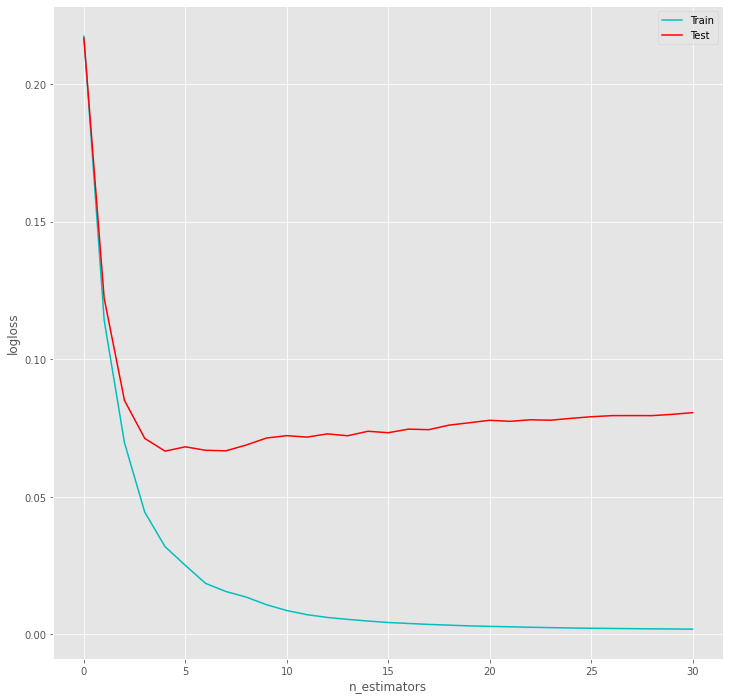

In [8]:
learning_curve(xgb1, 'logloss', X_train, y_train, X_test, y_test)

At the 5th Iteration the testing error started to drift;however, it is still below 0.1 which is good for such imbalanced problem 

Just as the we raised the threshold for the logistic regression model in the other notebook https://www.kaggle.com/code/omar1092837465/bankruptcy-classification-logistic-regression?scriptVersionId=105667651 in the classification report secion, raise it here too. 

In [9]:
def tune_threshold(y_probs, threshold):
    
    """ Predicts target with varing the threshold"""
    y_pred_with_threshold = []

    for prob in y_probs[:,1]:
            if prob > threshold:
                y_pred_with_threshold.append(1)
            else:
                y_pred_with_threshold.append(0)
    return y_pred_with_threshold

In [10]:
y_probs = xgb1.predict_proba(X_test)
y_pred = tune_threshold(y_probs, 0.9)

print(f'AUC: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))    

AUC: 0.8144449923296078
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1352
           1       0.97      0.63      0.76        54

    accuracy                           0.99      1406
   macro avg       0.98      0.81      0.88      1406
weighted avg       0.98      0.99      0.98      1406

[[1351    1]
 [  20   34]]


The model has 81% chance of distinguishing between non-bankrupt and bankrupt companies with a minimal false psoitive rate of (1/1+1351) = 0.073% 

## 6. Feature Importance

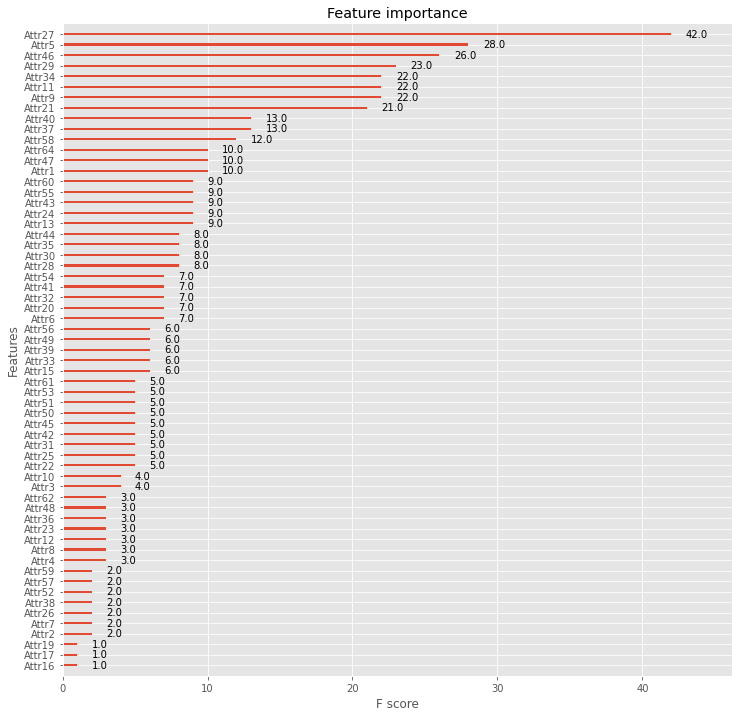

In [11]:
xgb.plot_importance(xgb1, max_num_features = 64);

Gradient Boosting performs way better than the intial model. 
* It has 81% chance of correctly classifying bankrupt from non=baankrupt companies and False Positive rate of 0.07%.
* Attr 27, 5, 46 contribute the most to the model and are the ones who frequently used when constructing the model.
* Previous Notebook https://www.kaggle.com/code/omar1092837465/bankruptcy-classification-logistic-regression?scriptVersionId=105667651